In [1]:
!pip install demucs torchaudio librosa numpy scipy matplotlib soundfile tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.1/87.1 kB 10.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 

In [1]:
pip install mir-eval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 2.8 MB/s eta 0:00:00


In [2]:
import os
os.environ["TORCH_COMPILE_DISABLE"] = "1"



In [3]:

import glob
import numpy as np
import librosa
import librosa.display
import torch
import torchaudio
import soundfile as sf
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
from mir_eval.separation import bss_eval_sources
from torch.utils.data import Dataset, DataLoader
from scipy.signal import butter, lfilter
from scipy.io.wavfile import write as wav_write

from demucs.apply import apply_model
from demucs import pretrained
import torch.nn as nn
import torch.optim as optim


In [4]:
# Load pre-trained Demucs model
model = pretrained.get_model("mdx_extra")
print(model)

# Freeze encoder layers for all models inside BagOfModels
for sub_model in model.models:
    for param in sub_model.encoder.parameters():
        param.requires_grad = False  # Keep pretrained weights

# Fine-tune decoder layers
for sub_model in model.models:
    for param in sub_model.decoder.parameters():
        param.requires_grad = True  # Allow training

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model loaded and fine-tuning enabled on {device}")


Downloading: "https://dl.fbaipublicfiles.com/demucs/mdx_final/e51eebcc-c1b80bdd.th" to /root/.cache/torch/hub/checkpoints/e51eebcc-c1b80bdd.th
100%|██████████| 160M/160M [00:02<00:00, 76.4MB/s]
Downloading: "https://dl.fbaipublicfiles.com/demucs/mdx_final/a1d90b5c-ae9d2452.th" to /root/.cache/torch/hub/checkpoints/a1d90b5c-ae9d2452.th
100%|██████████| 160M/160M [00:01<00:00, 114MB/s]
Downloading: "https://dl.fbaipublicfiles.com/demucs/mdx_final/5d2d6c55-db83574e.th" to /root/.cache/torch/hub/checkpoints/5d2d6c55-db83574e.th
100%|██████████| 160M/160M [00:01<00:00, 87.5MB/s]
Downloading: "https://dl.fbaipublicfiles.com/demucs/mdx_final/cfa93e08-61801ae1.th" to /root/.cache/torch/hub/checkpoints/cfa93e08-61801ae1.th
100%|██████████| 160M/160M [00:01<00:00, 101MB/s]


BagOfModels(
  (models): ModuleList(
    (0): HDemucs(
      (encoder): ModuleList(
        (0): HEncLayer(
          (conv): Conv2d(4, 48, kernel_size=(8, 1), stride=(4, 1), padding=(2, 0))
          (norm1): Identity()
          (rewrite): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
          (norm2): Identity()
          (dconv): DConv(
            (layers): ModuleList(
              (0): Sequential(
                (0): Conv1d(48, 12, kernel_size=(3,), stride=(1,), padding=(1,))
                (1): GroupNorm(1, 12, eps=1e-05, affine=True)
                (2): GELU(approximate='none')
                (3): Conv1d(12, 96, kernel_size=(1,), stride=(1,))
                (4): GroupNorm(1, 96, eps=1e-05, affine=True)
                (5): GLU(dim=1)
                (6): LayerScale()
              )
              (1): Sequential(
                (0): Conv1d(48, 12, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
                (1): GroupNorm(1, 12, eps=1e-05, affine=True

In [5]:
tracks = pd.read_csv("/content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_metadata/tracks.csv", index_col=0, header=[0, 1])
print("Columns in tracks.csv:", tracks.columns)

if ("track", "genre_top") in tracks.columns:
    # Select tracks with vocals
    relevant_genres = ["Pop", "Hip-Hop", "Jazz", "Blues"]
    vocal_tracks = tracks[tracks[("track", "genre_top")].isin(relevant_genres)]

    # Convert track IDs to string
    vocal_track_ids = set(vocal_tracks.index.astype(str))

    print(f"Found {len(vocal_track_ids)} vocal tracks matching genres {relevant_genres}")
else:
    raise ValueError("Genre column ('track', 'genre_top') not found in tracks.csv!")

print("Total vocal tracks selected:", len(vocal_track_ids))


Columns in tracks.csv: MultiIndex([( 'album',          'comments'),
            ( 'album',      'date_created'),
            ( 'album',     'date_released'),
            ( 'album',          'engineer'),
            ( 'album',         'favorites'),
            ( 'album',                'id'),
            ( 'album',       'information'),
            ( 'album',           'listens'),
            ( 'album',          'producer'),
            ( 'album',              'tags'),
            ( 'album',             'title'),
            ( 'album',            'tracks'),
            ( 'album',              'type'),
            ('artist', 'active_year_begin'),
            ('artist',   'active_year_end'),
            ('artist', 'associated_labels'),
            ('artist',               'bio'),
            ('artist',          'comments'),
            ('artist',      'date_created'),
            ('artist',         'favorites'),
            ('artist',                'id'),
            ('artist',          

In [6]:
FMA_FOLDER = "/content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small"
AUDIO_SAMPLE_RATE = 44100
NUM_FILES = 10  # Limit processing to avoid space issues
OUTPUT_FOLDER = "separated_files"



In [7]:
# Get paths of MP3 files corresponding to vocal tracks
AUDIO_FILES = glob.glob(os.path.join(FMA_FOLDER, "*/*.mp3"))
file_names = [os.path.basename(f).split(".")[0] for f in AUDIO_FILES]

selected_files = [
    f for f in AUDIO_FILES
    if os.path.basename(f).rsplit(".", 1)[0].lstrip("0") in vocal_track_ids
]


selected_files = np.random.choice(selected_files, min(NUM_FILES, len(selected_files)), replace=False)

print(f"Found {len(AUDIO_FILES)} total MP3 files.")
print(f"Selected {len(selected_files)} vocal files for processing.")


Found 4435 total MP3 files.
Selected 10 vocal files for processing.


In [8]:

os.makedirs("/content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_wav", exist_ok=True)

for file in tqdm(selected_files, desc="Converting MP3 to WAV"):
    y, sr = librosa.load(file, sr=AUDIO_SAMPLE_RATE, mono=False)
    file_name = os.path.basename(file).replace(".mp3", ".wav")

    # Normalize audio
    y = y / np.max(np.abs(y))  # Scale to [-1, 1]

    # Save using soundfile to avoid format issues
    sf.write(f"/content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_wav/{file_name}", y.T, sr, format='WAV', subtype='PCM_16')

print("MP3 files converted to WAV format")


Converting MP3 to WAV: 100%|██████████| 10/10 [00:29<00:00,  2.94s/it]

MP3 files converted to WAV format


In [9]:
def process_audio(file_path, input_model=None):
    """Loads an MP3 file, applies Demucs for vocal separation, and returns separated sources."""
    print(f"Processing {file_path}")

    # Load audio
    y, sr = librosa.load(file_path, sr=AUDIO_SAMPLE_RATE, mono=False)
    if y is None:
        print(f"Skipping {file_path} due to loading error.")
        return None, None, None  # Ensure 3 values are always returned

    print(f"Loaded Audio: Shape = {y.shape}, Sample Rate = {sr}")

    # Convert to tensor for model processing
    y_tensor = torch.tensor(y).unsqueeze(0).to(device)

    with torch.no_grad():
        if input_model:
            sources = apply_model(input_model, y_tensor)  # Use model if provided
        else:
            sources = apply_model(model, y_tensor)  # Default to pre-trained model

    sources = sources.cpu().numpy()
    print(f" Model Output Shape: {sources.shape}")

    # Extract vocals and instrumental
    vocals = sources[0, 0]
    instrumental = sources[0, 1] + sources[0, 2] + sources[0, 3]  # Sum non-vocal components

    return y, vocals, instrumental  # Always return 3 values


In [13]:
os.makedirs("separated_files", exist_ok=True)

for file in tqdm(selected_files, desc="Processing & Saving"):
    original, vocals, instrumental = process_audio(file, input_model=None)

    if original is None or vocals is None or instrumental is None:
        print(f"Skipping {file} due to missing values.")
        continue

    file_name = os.path.basename(file).replace(".mp3", "")

    vocals = np.asarray(vocals, dtype=np.float32).T
    instrumental = np.asarray(instrumental, dtype=np.float32).T

    sf.write(f"separated_files/{file_name}_vocals.wav", vocals, samplerate=AUDIO_SAMPLE_RATE)
    sf.write(f"separated_files/{file_name}_instrumental.wav", instrumental, samplerate=AUDIO_SAMPLE_RATE)

    print(f"Saved: separated_files/{file_name}_vocals.wav, separated_files/{file_name}_instrumental.wav")


Processing & Saving:   0%|          | 0/10 [00:00<?, ?it/s]

Processing /content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small/077/077564.mp3
Loaded Audio: Shape = (2, 1321967), Sample Rate = 44100


Processing & Saving:  10%|█         | 1/10 [00:03<00:33,  3.69s/it]

 Model Output Shape: (1, 4, 2, 1321967)
Saved: separated_files/077564_vocals.wav, separated_files/077564_instrumental.wav
Processing /content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small/040/040525.mp3
Loaded Audio: Shape = (2, 1321967), Sample Rate = 44100


Processing & Saving:  20%|██        | 2/10 [00:07<00:29,  3.68s/it]

 Model Output Shape: (1, 4, 2, 1321967)
Saved: separated_files/040525_vocals.wav, separated_files/040525_instrumental.wav
Processing /content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small/070/070768.mp3
Loaded Audio: Shape = (2, 1321967), Sample Rate = 44100


Processing & Saving:  30%|███       | 3/10 [00:10<00:25,  3.65s/it]

 Model Output Shape: (1, 4, 2, 1321967)
Saved: separated_files/070768_vocals.wav, separated_files/070768_instrumental.wav
Processing /content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small/019/019438.mp3
Loaded Audio: Shape = (2, 1323119), Sample Rate = 44100


Processing & Saving:  40%|████      | 4/10 [00:14<00:21,  3.64s/it]

 Model Output Shape: (1, 4, 2, 1323119)
Saved: separated_files/019438_vocals.wav, separated_files/019438_instrumental.wav
Processing /content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small/014/014365.mp3
Loaded Audio: Shape = (2, 1321967), Sample Rate = 44100


Processing & Saving:  50%|█████     | 5/10 [00:18<00:18,  3.63s/it]

 Model Output Shape: (1, 4, 2, 1321967)
Saved: separated_files/014365_vocals.wav, separated_files/014365_instrumental.wav
Processing /content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small/079/079616.mp3
Loaded Audio: Shape = (2, 1321967), Sample Rate = 44100


Processing & Saving:  60%|██████    | 6/10 [00:21<00:14,  3.63s/it]

 Model Output Shape: (1, 4, 2, 1321967)
Saved: separated_files/079616_vocals.wav, separated_files/079616_instrumental.wav
Processing /content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small/027/027551.mp3
Loaded Audio: Shape = (2, 1323119), Sample Rate = 44100


Processing & Saving:  70%|███████   | 7/10 [00:25<00:10,  3.63s/it]

 Model Output Shape: (1, 4, 2, 1323119)
Saved: separated_files/027551_vocals.wav, separated_files/027551_instrumental.wav
Processing /content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small/067/067365.mp3
Loaded Audio: Shape = (2, 1323119), Sample Rate = 44100


Processing & Saving:  80%|████████  | 8/10 [00:29<00:07,  3.63s/it]

 Model Output Shape: (1, 4, 2, 1323119)
Saved: separated_files/067365_vocals.wav, separated_files/067365_instrumental.wav
Processing /content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small/017/017496.mp3
Loaded Audio: Shape = (2, 1321967), Sample Rate = 44100


Processing & Saving:  90%|█████████ | 9/10 [00:32<00:03,  3.63s/it]

 Model Output Shape: (1, 4, 2, 1321967)
Saved: separated_files/017496_vocals.wav, separated_files/017496_instrumental.wav
Processing /content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small/078/078852.mp3
Loaded Audio: Shape = (2, 1323119), Sample Rate = 44100


Processing & Saving: 100%|██████████| 10/10 [00:36<00:00,  3.64s/it]

 Model Output Shape: (1, 4, 2, 1323119)
Saved: separated_files/078852_vocals.wav, separated_files/078852_instrumental.wav


In [14]:
class FMA_Dataset(Dataset):
    """Dataset for fine-tuning Demucs using FMA."""
    def __init__(self, data_path, sample_rate=44100, fixed_length=5.0):
        """
        Args:
            data_path: Path to dataset directory
            sample_rate: Audio sample rate (default 44100 Hz)
            fixed_length: Fixed length in seconds (default 5s)
        """
        self.data_path = data_path
        self.sample_rate = sample_rate
        self.fixed_samples = int(fixed_length * sample_rate)  # Convert seconds to samples
        self.files = [f for f in os.listdir(data_path) if f.endswith("_vocals.wav")]

    def __len__(self):
        return len(self.files)

    def load_audio(self, path):
        """Load an audio file and ensure it has the correct length."""
        audio, sr = torchaudio.load(path)

        # Ensure correct sample rate
        if sr != self.sample_rate:
            audio = torchaudio.transforms.Resample(sr, self.sample_rate)(audio)

        # If too short, pad with zeros
        if audio.shape[1] < self.fixed_samples:
            pad_size = self.fixed_samples - audio.shape[1]
            audio = torch.nn.functional.pad(audio, (0, pad_size))

        # If too long, trim to fixed length
        elif audio.shape[1] > self.fixed_samples:
            audio = audio[:, :self.fixed_samples]

        return audio

    def __getitem__(self, idx):
        vocal_path = os.path.join(self.data_path, self.files[idx])
        instrumental_path = vocal_path.replace("_vocals.wav", "_instrumental.wav")

        vocals = self.load_audio(vocal_path)
        instrumental = self.load_audio(instrumental_path)

        mix = vocals + instrumental  # Create the mix dynamically

        return mix, vocals  # Mix as input, vocals as target

# Reload dataset with fixed-length samples
train_dataset = FMA_Dataset("separated_files")
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

print(f"Training data loaded: {len(train_dataset)} samples")


Training data loaded: 10 samples


In [48]:
import torch
import librosa
import soundfile as sf
import numpy as np
import os

# Create a directory for saved models and separated files
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("separated_files", exist_ok=True)

# Regular fine-tuning
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, betas=(0.9, 0.999))

num_epochs = 10
training_losses_per_epoch = []

test_audio_path = "/content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small/090/090278.mp3"  # Test audio to evaluate each epoch

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for mix, vocals in train_loader:
        mix, vocals = mix.to(device), vocals.to(device)

        optimizer.zero_grad()
        predictions = apply_model(model, mix)[:, 0, :, :].requires_grad_(True)
        loss = criterion(predictions, vocals)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Compute average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    training_losses_per_epoch.append(avg_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.6f}")

    # Save model checkpoint
    checkpoint_path = f"/content/drive/MyDrive/Vocal_Seperation_Final_Project/Epochs/model_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Model saved: {checkpoint_path}")

    # Run inference & save separated files
    model.eval()  # Set to evaluation mode
    original_audio, predicted_vocals, predicted_instr = process_audio(test_audio_path, model)

    if original_audio is None or predicted_vocals is None or predicted_instr is None:
        print(f"Skipping {test_audio_path} due to missing values.")
        continue

    # Extract filename from path
    file_name = os.path.basename(test_audio_path).replace(".mp3", "")

    # Convert to float32 and ensure correct shape
    predicted_vocals = np.asarray(predicted_vocals, dtype=np.float32).T
    predicted_instr = np.asarray(predicted_instr, dtype=np.float32).T

    # Save as WAV with epoch-specific filenames
    sf.write(f"/content/drive/MyDrive/Vocal_Seperation_Final_Project/Seperated_files_epochs/{file_name}_vocals_epoch_{epoch+1}.wav", predicted_vocals, 44100, format='WAV')
    sf.write(f"/content/drive/MyDrive/Vocal_Seperation_Final_Project/Seperated_files_epochs/{file_name}_instrumental_epoch_{epoch+1}.wav", predicted_instr, 44100, format='WAV')

    print(f"Separated audio saved for epoch {epoch+1}")

print("Fine-tuning completed!")

Epoch 1/10, Loss: 0.004829
Model saved: /content/drive/MyDrive/Vocal_Seperation_Final_Project/Epochs/model_epoch_1.pth
Processing /content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small/090/090278.mp3
Loaded Audio: Shape = (2, 1323119), Sample Rate = 44100
 Model Output Shape: (1, 4, 2, 1323119)
Separated audio saved for epoch 1
Epoch 2/10, Loss: 0.005046
Model saved: /content/drive/MyDrive/Vocal_Seperation_Final_Project/Epochs/model_epoch_2.pth
Processing /content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small/090/090278.mp3
Loaded Audio: Shape = (2, 1323119), Sample Rate = 44100
 Model Output Shape: (1, 4, 2, 1323119)
Separated audio saved for epoch 2
Epoch 3/10, Loss: 0.004806
Model saved: /content/drive/MyDrive/Vocal_Seperation_Final_Project/Epochs/model_epoch_3.pth
Processing /content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small/090/090278.mp3
Loaded Audio: Shape = (2, 1323119), Sample Rate = 44100
 Model Output Shape: (1, 4, 2, 1323119)
Separated audio s

In [25]:
# Load model checkpoint for epoch 3
checkpoint_path = "/content/drive/MyDrive/Vocal_Seperation_Final_Project/Epochs/model_epoch_3.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

print("Model checkpoint for Epoch 3 loaded!")

<ipython-input-25-3da441a0c3d0>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


Model checkpoint for Epoch 3 loaded!


In [51]:
import torch
import numpy as np

# Load model checkpoint for epoch 3
checkpoint_path = f"/content/drive/MyDrive/Vocal_Seperation_Final_Project/Epochs/model_epoch_3.pth"
model.load_state_dict(torch.load(checkpoint_path))
model.eval()  # Set to evaluation mode
print(f" Model loaded from {checkpoint_path}")

# Process the test audio using the loaded model from epoch 3
test_audio_path = "/content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small/090/090278.mp3"  # Test audio to evaluate each epoch
original_audio, predicted_vocals, predicted_instr = process_audio(test_audio_path, model)

# Ensure correct shape before computing metrics
predicted_sources = np.vstack([predicted_vocals, predicted_instr])  # Stack separated sources

# Compute SDR, SIR, SAR for epoch 3
sdr, sir, sar = compute_metrics(original_audio, predicted_sources)

# Print results
print(f"Epoch 3 Metrics:")
print(f"SDR: {sdr:.2f}")
print(f"SIR: {sir:.2f}")
print(f"SAR: {sar:.2f}")

<ipython-input-51-23d7c04ada28>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


 Model loaded from /content/drive/MyDrive/Vocal_Seperation_Final_Project/Epochs/model_epoch_3.pth
Processing /content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small/090/090278.mp3
Loaded Audio: Shape = (2, 1323119), Sample Rate = 44100
 Model Output Shape: (1, 4, 2, 1323119)


<ipython-input-40-9c51967ff59c>:8: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = bss_eval_sources(original, separated)


Epoch 3 Metrics:
SDR: 8.25
SIR: 21.38
SAR: 8.50


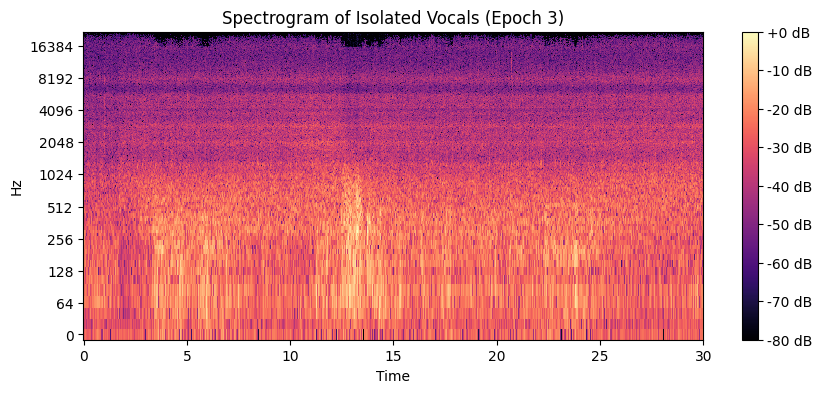

In [50]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load audio output from epoch 3
vocal_audio, _ = librosa.load("/content/drive/MyDrive/Vocal_Seperation_Final_Project/Seperated_files_epochs/090278_instrumental_epoch_3.wav", sr=44100)

# Compute Spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(vocal_audio)), ref=np.max)

# Plot Spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=44100, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram of Isolated Vocals (Epoch 3)")
plt.show()

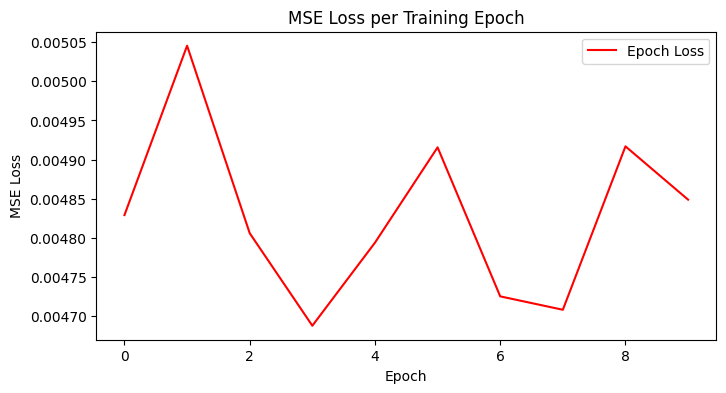

BagOfModels(
  (models): ModuleList(
    (0): HDemucs(
      (encoder): ModuleList(
        (0): HEncLayer(
          (conv): Conv2d(4, 48, kernel_size=(8, 1), stride=(4, 1), padding=(2, 0))
          (norm1): Identity()
          (rewrite): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
          (norm2): Identity()
          (dconv): DConv(
            (layers): ModuleList(
              (0): Sequential(
                (0): Conv1d(48, 12, kernel_size=(3,), stride=(1,), padding=(1,))
                (1): GroupNorm(1, 12, eps=1e-05, affine=True)
                (2): GELU(approximate='none')
                (3): Conv1d(12, 96, kernel_size=(1,), stride=(1,))
                (4): GroupNorm(1, 96, eps=1e-05, affine=True)
                (5): GLU(dim=1)
                (6): LayerScale()
              )
              (1): Sequential(
                (0): Conv1d(48, 12, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
                (1): GroupNorm(1, 12, eps=1e-05, affine=True

In [49]:

# **Plot MSE Loss per Epoch**
plt.figure(figsize=(8, 4))
plt.plot(training_losses_per_epoch, label="Epoch Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("MSE Loss per Training Epoch")
plt.legend()
plt.show()

# Load the fine-tuned model
model.eval()  # Set to evaluation mode

In [28]:
#fine tuning with different hyperparams - expirament 1
# Define hyperparameter search space
learning_rates = [1e-3, 1e-4, 1e-5]
batch_sizes = [4, 8, 16]
optimizers = [optim.Adam, optim.SGD, optim.RMSprop]

# Store results
experiment_results = []

# Iterate over all hyperparameter combinations
for lr in learning_rates:
    for batch_size in batch_sizes:
        for opt in optimizers:
            print(f"\n Training with {opt.__name__}, LR={lr}, Batch Size={batch_size}")

            # Update DataLoader with new batch size
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            # Initialize optimizer
            optimizer = opt(model.parameters(), lr=lr)

            # Training settings
            criterion = nn.L1Loss()
            num_epochs = 10
            training_losses = []

            # Training loop
            for epoch in range(num_epochs):
                model.train()
                total_loss = 0

                for mix, vocals in train_loader:
                    mix, vocals = mix.to(device), vocals.to(device)

                    optimizer.zero_grad()
                    predictions = apply_model(model, mix)[:, 0, :, :].requires_grad_(True)
                    loss = criterion(predictions, vocals)
                    loss.backward()
                    optimizer.step()

                    total_loss += loss.item()

                avg_loss = total_loss / len(train_loader)
                training_losses.append(avg_loss)
                print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.6f}")

            print("Fine-tuning completed!")

            # Save results
            experiment_results.append((opt.__name__, lr, batch_size, min(training_losses)))

# Convert results to DataFrame for analysis
df_experiments = pd.DataFrame(experiment_results, columns=["Optimizer", "Learning Rate", "Batch Size", "Min Loss"])
print("\n Experiment Results:")
print(df_experiments)

# Save results
df_experiments.to_csv("hyperparameter_experiments.csv", index=False)



 Training with Adam, LR=0.001, Batch Size=4
Epoch 1/10, Loss: 0.004897
Epoch 2/10, Loss: 0.005197
Epoch 3/10, Loss: 0.004376
Epoch 4/10, Loss: 0.004165
Epoch 5/10, Loss: 0.005150
Epoch 6/10, Loss: 0.005115
Epoch 7/10, Loss: 0.005156
Epoch 8/10, Loss: 0.004358
Epoch 9/10, Loss: 0.005370
Epoch 10/10, Loss: 0.004363
Fine-tuning completed!

 Training with SGD, LR=0.001, Batch Size=4
Epoch 1/10, Loss: 0.004582
Epoch 2/10, Loss: 0.005949
Epoch 3/10, Loss: 0.004514
Epoch 4/10, Loss: 0.004757
Epoch 5/10, Loss: 0.004239
Epoch 6/10, Loss: 0.005605
Epoch 7/10, Loss: 0.004723
Epoch 8/10, Loss: 0.005648
Epoch 9/10, Loss: 0.004964
Epoch 10/10, Loss: 0.005226
Fine-tuning completed!

 Training with RMSprop, LR=0.001, Batch Size=4
Epoch 1/10, Loss: 0.005124
Epoch 2/10, Loss: 0.004462
Epoch 3/10, Loss: 0.005498
Epoch 4/10, Loss: 0.004616
Epoch 5/10, Loss: 0.005163
Epoch 6/10, Loss: 0.005709
Epoch 7/10, Loss: 0.004171
Epoch 8/10, Loss: 0.004783
Epoch 9/10, Loss: 0.005072
Epoch 10/10, Loss: 0.004640
Fine

In [30]:
# Convert results to DataFrame for analysis
df_experiments = pd.DataFrame(experiment_results, columns=["Optimizer", "Learning Rate", "Batch Size", "Min Loss"])
print("\n Experiment Results:")
print(df_experiments)

# Save results
df_experiments.to_csv("hyperparameter_experiments.csv", index=False)


 Experiment Results:
   Optimizer  Learning Rate  Batch Size  Min Loss
0       Adam        0.00100           4  0.004165
1        SGD        0.00100           4  0.004239
2    RMSprop        0.00100           4  0.004171
3       Adam        0.00100           8  0.003413
4        SGD        0.00100           8  0.003625
5    RMSprop        0.00100           8  0.003813
6       Adam        0.00100          16  0.004736
7        SGD        0.00100          16  0.004796
8    RMSprop        0.00100          16  0.004847
9       Adam        0.00010           4  0.004459
10       SGD        0.00010           4  0.004633
11   RMSprop        0.00010           4  0.004522
12      Adam        0.00010           8  0.004457
13       SGD        0.00010           8  0.003296
14   RMSprop        0.00010           8  0.003490
15      Adam        0.00010          16  0.004673
16       SGD        0.00010          16  0.004803
17   RMSprop        0.00010          16  0.004746
18      Adam        0.00001 

In [31]:
model.eval()

BagOfModels(
  (models): ModuleList(
    (0): HDemucs(
      (encoder): ModuleList(
        (0): HEncLayer(
          (conv): Conv2d(4, 48, kernel_size=(8, 1), stride=(4, 1), padding=(2, 0))
          (norm1): Identity()
          (rewrite): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
          (norm2): Identity()
          (dconv): DConv(
            (layers): ModuleList(
              (0): Sequential(
                (0): Conv1d(48, 12, kernel_size=(3,), stride=(1,), padding=(1,))
                (1): GroupNorm(1, 12, eps=1e-05, affine=True)
                (2): GELU(approximate='none')
                (3): Conv1d(12, 96, kernel_size=(1,), stride=(1,))
                (4): GroupNorm(1, 96, eps=1e-05, affine=True)
                (5): GLU(dim=1)
                (6): LayerScale()
              )
              (1): Sequential(
                (0): Conv1d(48, 12, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
                (1): GroupNorm(1, 12, eps=1e-05, affine=True

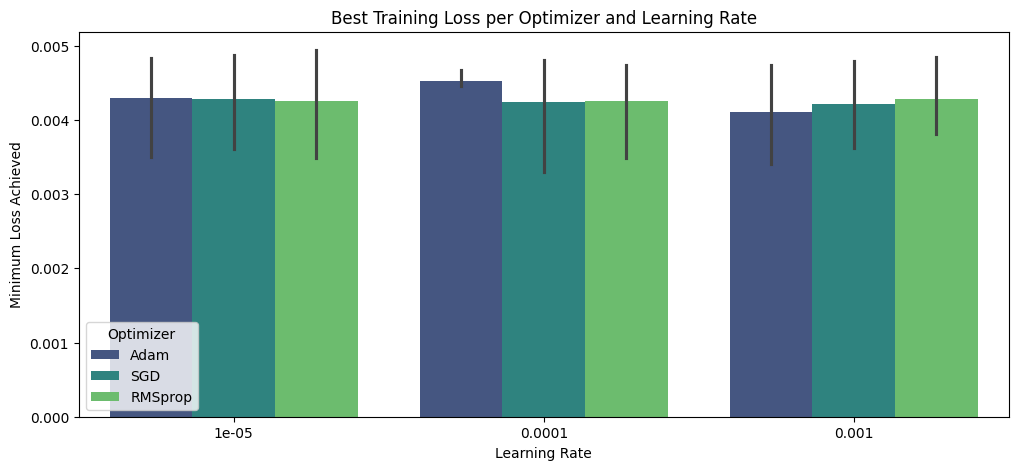

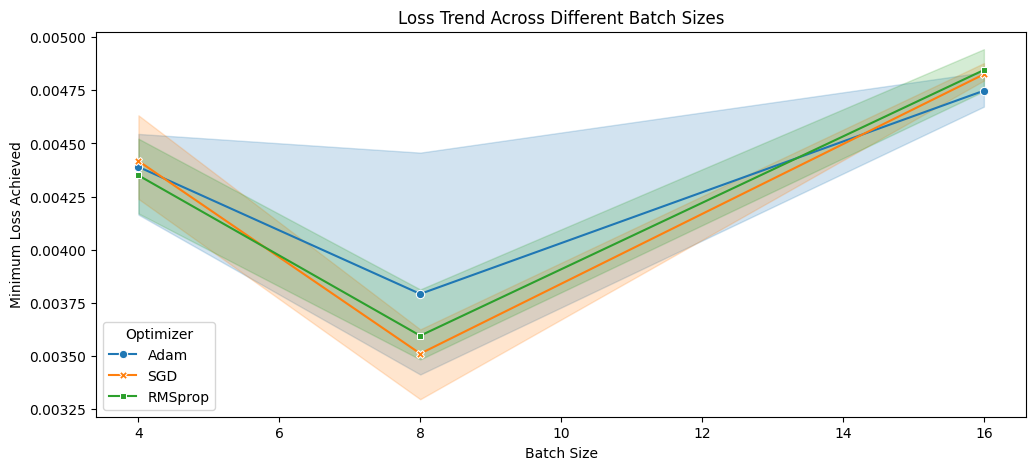


 Experiment results saved to hyperparameter_experiments.csv


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure DataFrame contains the correct columns
df_experiments = pd.DataFrame(experiment_results, columns=["Optimizer", "Learning Rate", "Batch Size", "Min Loss"])

# Bar Chart: Minimum Loss per Optimizer & Learning Rate
plt.figure(figsize=(12, 5))
sns.barplot(x="Learning Rate", y="Min Loss", hue="Optimizer", data=df_experiments, palette="viridis")
plt.title("Best Training Loss per Optimizer and Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Minimum Loss Achieved")
plt.legend(title="Optimizer")
plt.show()

# Line Graph: Loss Trend Across Batch Sizes
plt.figure(figsize=(12, 5))
sns.lineplot(x="Batch Size", y="Min Loss", hue="Optimizer", style="Optimizer", data=df_experiments, markers=True, dashes=False)
plt.title("Loss Trend Across Different Batch Sizes")
plt.xlabel("Batch Size")
plt.ylabel("Minimum Loss Achieved")
plt.legend(title="Optimizer")
plt.show()

# Save results to CSV
df_experiments.to_csv("hyperparameter_experiments.csv", index=False)
print("\n Experiment results saved to hyperparameter_experiments.csv")


In [39]:


# Get all MP3 files from subdirectories
all_mp3_files = glob.glob(os.path.join("/content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small", "*/*.mp3"))  # Recursively fetch files

# Pick test files that were NOT used in fine-tuning
test_files = [f for f in all_mp3_files if f not in selected_files][:10]  # Select 10 unseen files

print(f"Selected {len(test_files)} test files.")


Selected 10 test files.


In [40]:
def compute_metrics(original, separated):
    """Computes SDR, SIR, and SAR for separated vocals."""
    try:
        min_length = min(original.shape[1], separated.shape[1])
        original = original[:, :min_length]
        separated = separated[:2, :min_length]  # Ensure only two sources

        sdr, sir, sar, _ = bss_eval_sources(original, separated)
        return np.mean(sdr), np.mean(sir), np.mean(sar)
    except Exception as e:
        print(f"Error computing metrics: {e}")
        return None, None, None


In [41]:
evaluation_results = []

for file in test_files:
    print(f"\n Evaluating: {file}")

    # Process file through the fine-tuned model
    original_audio, predicted_vocals, predicted_instr = process_audio(file, model)

    if original_audio is not None and predicted_vocals is not None:
        sdr, sir, sar = compute_metrics(original_audio, np.vstack([predicted_vocals, predicted_instr]))

        evaluation_results.append((file, sdr, sir, sar))
        print(f"{file}: SDR={sdr:.2f}, SIR={sir:.2f}, SAR={sar:.2f}")

# Convert results to DataFrame
df_results = pd.DataFrame(evaluation_results, columns=["Track", "SDR", "SIR", "SAR"])
print("\n Evaluation Results:")
print(df_results)

# Save results to CSV
df_results.to_csv("fine_tuning_evaluation.csv", index=False)



 Evaluating: /content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small/056/056248.mp3
Processing /content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small/056/056248.mp3
Loaded Audio: Shape = (2, 1321967), Sample Rate = 44100
 Model Output Shape: (1, 4, 2, 1321967)


<ipython-input-40-9c51967ff59c>:8: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = bss_eval_sources(original, separated)


/content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small/056/056248.mp3: SDR=2.45, SIR=16.04, SAR=2.76

 Evaluating: /content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small/056/056249.mp3
Processing /content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small/056/056249.mp3
Loaded Audio: Shape = (2, 1321967), Sample Rate = 44100
 Model Output Shape: (1, 4, 2, 1321967)
/content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small/056/056249.mp3: SDR=-15.49, SIR=2.66, SAR=-13.47

 Evaluating: /content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small/056/056033.mp3
Processing /content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small/056/056033.mp3
Loaded Audio: Shape = (2, 1323119), Sample Rate = 44100
 Model Output Shape: (1, 4, 2, 1323119)
/content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small/056/056033.mp3: SDR=34.47, SIR=46.74, SAR=34.76

 Evaluating: /content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small/056/056020.mp3
Processing /co

In [43]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def plot_spectrogram(audio, sr, title):
    """Plots the spectrogram of an audio signal."""
    plt.figure(figsize=(10, 4))
    S = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(S, sr=sr, x_axis="time", y_axis="log")
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.show()




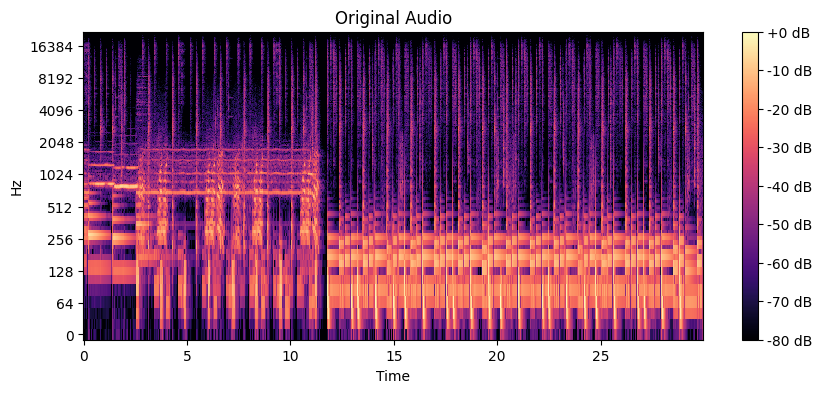

Processing /content/drive/MyDrive/Vocal_Seperation_Final_Project/fma_small/056/056248.mp3
Loaded Audio: Shape = (2, 1321967), Sample Rate = 44100
 Model Output Shape: (1, 4, 2, 1321967)


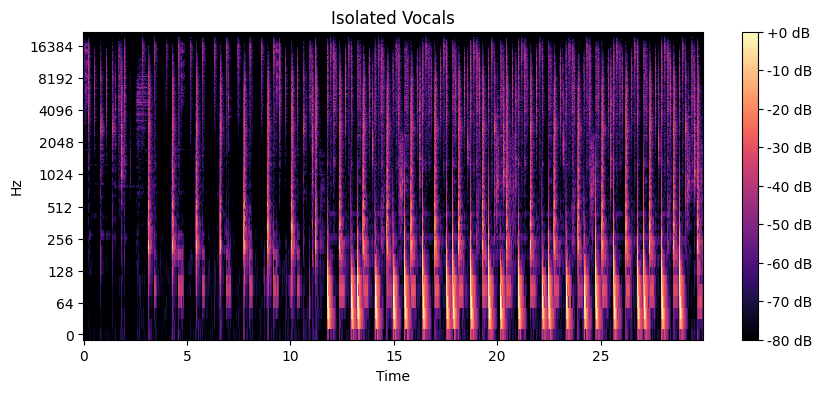

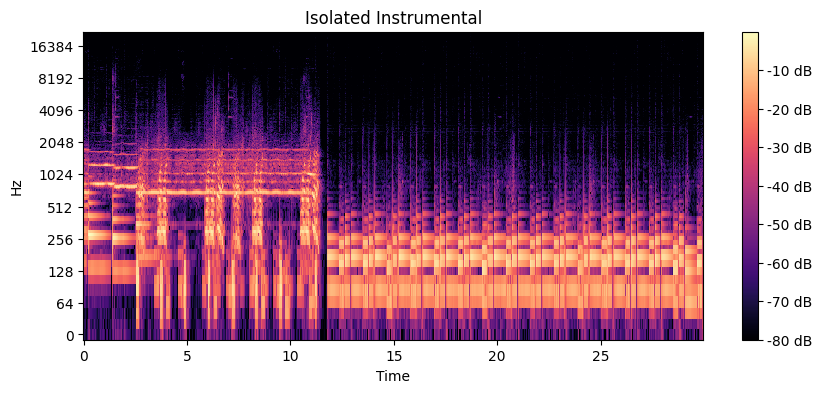

In [44]:
# Load test file for visualization
test_file = test_files[0]  # Use the first file from the test set
y, sr = librosa.load(test_file, sr=AUDIO_SAMPLE_RATE, mono=True)
plot_spectrogram(y, sr, "Original Audio")

# Process file through the fine-tuned model
original, vocals, instrumental = process_audio(test_file, input_model=model)  # Uses updated process_audio function

# Ensure correct shape before plotting
if vocals is not None and instrumental is not None:
    plot_spectrogram(vocals[0], sr, "Isolated Vocals")  # Take channel 0 if stereo
    plot_spectrogram(instrumental[0], sr, "Isolated Instrumental")  # Take channel 0 if stereo
else:
    print(f"Error processing {test_file}, skipping visualization.")

Epoch 1/10, Train Loss: 0.004878, Test Loss: 0.005586
Epoch 2/10, Train Loss: 0.005250, Test Loss: 0.005016
Epoch 3/10, Train Loss: 0.005075, Test Loss: 0.005909
Epoch 4/10, Train Loss: 0.004594, Test Loss: 0.005393
Epoch 5/10, Train Loss: 0.004868, Test Loss: 0.005547
Epoch 6/10, Train Loss: 0.004885, Test Loss: 0.005363
Epoch 7/10, Train Loss: 0.004884, Test Loss: 0.005627
Epoch 8/10, Train Loss: 0.004567, Test Loss: 0.005083
Epoch 9/10, Train Loss: 0.004810, Test Loss: 0.005723
Epoch 10/10, Train Loss: 0.004454, Test Loss: 0.005162
Training and Evaluation Completed!


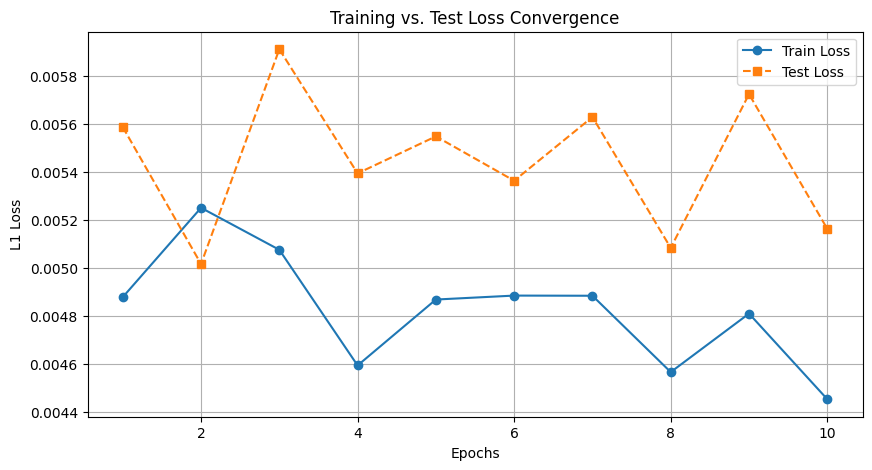

In [52]:
"""
This part performs the following steps:

1. Splits the dataset into training (80%) and test (20%) subsets.
2. Creates DataLoaders for batching and shuffling.
3. Defines a model, L1 loss function, and Adam optimizer.
4. Trains the model for a specified number of epochs, computing and storing
   the training and test loss at each epoch.
5. Evaluates the model on the test set without gradient computation.
6. Plots the training and test loss to visualize model convergence.

"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Define Dataset Split (Train/Test)
train_size = int(0.8 * len(train_dataset))  # 80% for training
test_size = len(train_dataset) - train_size  # 20% for testing
train_subset, test_subset = random_split(train_dataset, [train_size, test_size])

# Create Train and Test DataLoaders
train_loader = DataLoader(train_subset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=8, shuffle=False)  # No shuffling for test data

# Define Model, Loss Function, Optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, betas=(0.9, 0.999))

# Initialize Lists to Store Losses
num_epochs = 10
training_losses_per_epoch = []  # Track training loss per epoch
test_losses_per_epoch = []  # Track test loss per epoch

# Training and Evaluation Loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    # Training Loop
    for mix, vocals in train_loader:
        mix, vocals = mix.to(device), vocals.to(device)

        optimizer.zero_grad()
        predictions = apply_model(model, mix)[:, 0, :, :].requires_grad_(True)
        loss = criterion(predictions, vocals)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    # Compute average training loss for this epoch
    avg_train_loss = total_train_loss / len(train_loader)
    training_losses_per_epoch.append(avg_train_loss)

    # Compute Test Loss for This Epoch
    model.eval()
    total_test_loss = 0

    with torch.no_grad():  # Disable gradient computation
        for mix, vocals in test_loader:
            mix, vocals = mix.to(device), vocals.to(device)
            predictions = apply_model(model, mix)[:, 0, :, :]
            loss = criterion(predictions, vocals)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses_per_epoch.append(avg_test_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")

print("Training and Evaluation Completed!")

# Plot Training vs. Test Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_losses_per_epoch, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs + 1), test_losses_per_epoch, label="Test Loss", marker='s', linestyle='dashed')

plt.xlabel("Epochs")
plt.ylabel("L1 Loss")
plt.title("Training vs. Test Loss Convergence")
plt.legend()
plt.grid(True)
plt.show()
